# **Data Wrangling, EDA and Features Engineering: Retail ActionAI: Next-Best-Offer**

## **Introduction**

**Problem statement**

Retail ActionAI has one clear business goal: **spend every promotion dollar where it actually changes behaviour.**  
Using Instacart's historical baskets, we want to answer—**for each shopper-item pair right now**:

> *“Will this person put this item in their very next order?”*

If the answer is **very likely**, a coupon is wasted.  
If it's **unlikely but within reach**, a smart offer—like a discount or upsell—might win the sale.  
So the core technical task is a **"buy-next" prediction** at the *(user, product)* level.

**Justification for this formulation**

* **Granular ROI**: Modeling individual user-product pairs helps us apply offers with precision.
* **Behavior-Aware Offers**: Based on user engagement and purchase intent, we tailor offers (coupon, upsell, or none).
* **Operational Flexibility**: The business layer can evolve rules (e.g., budget caps, product exclusions) without retraining the model.

**Proposed approach**

| Layer | Role |
|-------|------|
| **Feature Engineering** | Turn raw basket logs into rich shopper, product, time, and user-product features |
| **Binary Classifier** | Predict `p_buy = P(item appears in shopper's next order)` |
| **NBO Assignment Logic** | Use `p_buy` and behavioral thresholds to choose between **"None"**, **"Coupon"**, or **"Upsell"** |

---

**Notebook roadmap**

| Stage | What We Do | Key Artefacts |
|-------|------------|---------------|
| **Data Wrangling** | Load Instacart data, optimize dtypes, join look-ups &rarr; `prior_full` | Cleaned basket log |
| **Feature Engineering** | Create:<br>• Shopper features<br>• Product features<br>• Time features<br>• User x Product interactions | 4 feature blocks |
| **Modeling Dataset** | Build labeled matrix with `bought_next`, clip outliers, balance classes | `candidates` dataset |
| **Model Training + NBO Engine** | Calibrate a model, score each row, apply NBO rules | Model + business logic layer |

With a clean, feature-rich dataset and a well-framed target (`bought_next`), we're ready to build the engine that turns raw basket data into profit-maximising next-best offers (NBO).


## **Dataset**

* **Source:** Instacart Market Basket Analysis [Kaggle](https://www.kaggle.com/datasets/psparks/instacart-market-basket-analysis/data).

* **Scope:** ~3.4 M orders from 206 K users, 30 K products, 134 aisles, 21 departments.

* **Core tables:**

  * orders: one row per purchase

  * order_products__prior & order_products__train: product-level lines

  * products, aisles, departments: product &harr; category look-ups

These six tables connect on order_id, product_id, aisle_id, and department_id to give us a full picture from product to basket to customer.

## **Importing Necessary Libraries**

In [1]:
import kagglehub
import pathlib
import zipfile
import os
import textwrap
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.stats import entropy

## **Helper Functions**

In [2]:
def summarize(df):
    """
    Generate a summary for our df including: unique_count, data_types, missing_counts and missing_percentage
    """
    # No. of unique values for each column:
    unique_counts = df.nunique()
    # Data types of each column:
    data_types = df.dtypes
    # No. of missing (NaN) values in each column:
    missing_counts = df.isnull().sum()
    # Percentage of missing values in each column:
    missing_percentage = 100 * df.isnull().mean()
    # Concatenate the above metrics:
    summary_df = pd.concat([unique_counts, data_types, missing_counts, missing_percentage], axis=1)
    # Rename the columns for better readibility
    summary_df.columns = ['unique_count', 'data_types', 'missing_counts', 'missing_percentage']
    # Reset index to turn column names into a proper column:
    summary_df = summary_df.reset_index().rename(columns={'index': 'feature'})
    # Return summary df
    return summary_df
#-----------------------------------------------------------------------------------------------------------------#
def value_counts_with_percentage(df, column_name):
    # Calculate value counts
    counts = df[column_name].value_counts(dropna=False)

    # Calculate percentages
    percentages = df[column_name].value_counts(dropna=False, normalize=True) * 100

    # Combine counts and percentages into a DataFrame
    result = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages
    })

    return result

## **Importing Instacart Tables**

Before we can model anything, we need to pull the raw Instacart files into Colab, load them efficiently, and stitch them into one wide table that's ready for feature engineering.

* **Mount Drive & unzip**: Extract `instacart_datasets.zip` to `/content/instacart_data` in my google drive.

* **Quick sanity check**: List every CSV in that folder and print its size and row-count to confirm nothing is missing.

* **Memory-safe loads**: Read each table with compact dtypes (`int32 / int16 / int8` for IDs and counts, one `float32` for `days_since_prior_order`).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# First, let's unzip into a clean working folder:
!mkdir -p /content/instacart_data
!unzip -q "/content/drive/My Drive/Colab Notebooks/instacart_datasets.zip" -d /content/instacart_data

In [5]:
DATA_DIR = pathlib.Path("/content/instacart_data")

# Then, let's start inspecting the files by listing existing tables and their sizes:
for p in sorted(DATA_DIR.glob("*.csv")):
    size_mb = p.stat().st_size / (1024**2)
    print(f"{p.name:<32} {size_mb:6.1f} MB")

aisles.csv                          0.0 MB
departments.csv                     0.0 MB
order_products__prior.csv         550.8 MB
order_products__train.csv          23.5 MB
orders.csv                        103.9 MB
products.csv                        2.1 MB


In [6]:
# row counts:
def count_rows(path):
    with open(path, "rb") as f:
        return sum(1 for _ in f) - 1

In [7]:
#Here, let's count the rows for each table:
print("\nRows count per table:")
for p in sorted(DATA_DIR.glob("*.csv")):
    print(f"{p.name:<32} {count_rows(p):>10,}")


Rows count per table:
aisles.csv                              134
departments.csv                          21
order_products__prior.csv        32,434,489
order_products__train.csv         1,384,617
orders.csv                        3,421,083
products.csv                         49,688


In [8]:
# here, let's import in all these tables:
orders   = pd.read_csv(DATA_DIR / "orders.csv",
                       dtype={"order_id":"int32","user_id":"int32",
                              "order_number":"int16","order_dow":"int8",
                              "order_hour_of_day":"int8",
                              "days_since_prior_order":"float32"})
prior    = pd.read_csv(DATA_DIR / "order_products__prior.csv",
                       dtype={"order_id":"int32","product_id":"int32",
                              "add_to_cart_order":"int16","reordered":"int8"})
train    = pd.read_csv(DATA_DIR / "order_products__train.csv",
                       dtype=prior.dtypes.to_dict())
products = pd.read_csv(DATA_DIR / "products.csv",
                       dtype={"product_id":"int32","aisle_id":"int16",
                              "department_id":"int8"})
aisles      = pd.read_csv(DATA_DIR / "aisles.csv",      dtype={"aisle_id":"int16"})
departments = pd.read_csv(DATA_DIR / "departments.csv", dtype={"department_id":"int8"})


In [9]:
# Now let's look at the shape for each table:
dfs = {
    "orders"        : orders,
    "order_prior"   : prior,
    "order_train"   : train,
    "products"      : products,
    "aisles"        : aisles,
    "departments"   : departments,
}

print("Table shapes:")
for name, df in dfs.items():
    print(f"{name:<15} {df.shape[0]:>10,} rows   {df.shape[1]:>3} cols")

Table shapes:
orders           3,421,083 rows     7 cols
order_prior     32,434,489 rows     4 cols
order_train      1,384,617 rows     4 cols
products            49,688 rows     4 cols
aisles                 134 rows     2 cols
departments             21 rows     2 cols


In [11]:
# Alright here, let's review top 5 rows for each table:
for name, df in dfs.items():
    print(f"\n{name} (top 5 rows):")
    display(df.head(5))


orders (top 5 rows):


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0



order_prior (top 5 rows):


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0



order_train (top 5 rows):


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1



products (top 5 rows):


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13



aisles (top 5 rows):


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation



departments (top 5 rows):


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [12]:
# Alright now let's inspect each tables in terms of unique counts, datatypes and missing data info:
for name, df in dfs.items():
    print(f"\n{name} summary:")
    display(summarize(df))


orders summary:


,feature,unique_count,data_types,missing_counts,missing_percentage
0,order_id,3421083,int32,0,0.000000
1,user_id,206209,int32,0,0.000000
2,eval_set,3,object,0,0.000000
3,order_number,100,int16,0,0.000000
4,order_dow,7,int8,0,0.000000
5,order_hour_of_day,24,int8,0,0.000000
6,days_since_prior_order,31,float32,206209,6.027594



order_prior summary:


,feature,unique_count,data_types,missing_counts,missing_percentage
0,order_id,3214874,int32,0,0.0
1,product_id,49677,int32,0,0.0
2,add_to_cart_order,145,int16,0,0.0
3,reordered,2,int8,0,0.0



order_train summary:


,feature,unique_count,data_types,missing_counts,missing_percentage
0,order_id,131209,int32,0,0.0
1,product_id,39123,int32,0,0.0
2,add_to_cart_order,80,int16,0,0.0
3,reordered,2,int8,0,0.0



products summary:


,feature,unique_count,data_types,missing_counts,missing_percentage
0,product_id,49688,int32,0,0.0
1,product_name,49688,object,0,0.0
2,aisle_id,134,int16,0,0.0
3,department_id,21,int8,0,0.0



aisles summary:


,feature,unique_count,data_types,missing_counts,missing_percentage
0,aisle_id,134,int16,0,0.0
1,aisle,134,object,0,0.0



departments summary:


,feature,unique_count,data_types,missing_counts,missing_percentage
0,department_id,21,int8,0,0.0
1,department,21,object,0,0.0


## **Data Wrangling**

This step polishes the raw Instacart tables so they join cleanly, fit in memory, and feed the model reliable inputs. Below is the game-plan and what each sub-section tackles:

* **Data types:** keep integers small and consistent by:
  * Cast join keys to compact ints (`int32`, `int16`, `int8`) so merges don't up-cast to `int64`.
  * Down-cast the one float column (`days_since_prior_order`) to `float32` to save RAM.

* **Remove duplicates:**  This will guarantee one factual row per record:
  * `df.drop_duplicates()` on every table—cheap insurance against accidental repeats.
  * Leaner tables speed up the big merge and later group-bys.

* **Joining the tables**: build a single, product-rich history view:
  * Merge `products `&rarr;` aisles `&rarr; `departments` into a **product lookup**.  
  * Join that lookup to `order_products__prior`, then attach the `orders` header. The result **`prior_full`** has one row per product in every past basket, plus aisle, department, order time, etc.   

* **Missing data**: Here we will plug the only nulls to keep the column fully numeric.
  * `days_since_prior_order` is missing on a shopper's first-ever order. we'll
  fill with **0** (no prior gap) and convert to `int16`.

* **Object to category conversion:** We'll trim memory for small text columns by:
  *  Convert low-cardinality strings (`aisle`, `department`, `eval_set`) to `category`.  
  * Leave `product_name` as plain text; ~50 K unique values mean categorising it bloats rather than helps.  
   

### **Data types**

Here, we'll keep integers small and consistent by:
  * Cast join keys to compact ints (`int32`, `int16`, `int8`) so merges don't up-cast to `int64`.
  * Down-cast the one float column (`days_since_prior_order`) to `float32` to save RAM.


   

In [13]:
# Alright at first let's make sure we have same dtypes across all tables:
key_dtypes = {"order_id":"int32",
              "user_id":"int32",
              "product_id":"int32",
              "aisle_id":"int16",
              "department_id":"int8"}
for df in [orders, prior, train, products, aisles, departments]:
    for k, t in key_dtypes.items():
        if k in df.columns:
            df[k] = df[k].astype(t)

### **Remove duplicates**  

This will guarantee one factual row per record:
  * `df.drop_duplicates()` on every table—cheap insurance against accidental repeats.
  * Leaner tables speed up the big merge and later group-bys.



In [14]:
# Here's let's drop the duplicates if any:

for df in [orders, prior, train, products, aisles, departments]:
    df.drop_duplicates(inplace=True)

### **Joining the tables**

Here let's build a single, product-rich history view:
  * Merge `products `&rarr;` aisles `&rarr; `departments` into a **product lookup**.  
  * Join that lookup to `order_products__prior`, then attach the `orders` header. The result **`prior_full`** has one row per product in every past basket, plus aisle, department, order time, etc.   



In [15]:
# Now, let's join the tables:
prod_detail = (products
               .merge(aisles, on="aisle_id")
               .merge(departments, on="department_id"))
prior_full = (prior
              .merge(prod_detail, on="product_id", how="left")
              .merge(orders,      on="order_id",   how="left"))

In [16]:
prior_full.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


### **Missing data**

Here we will plug the only nulls to keep the column fully numeric. `days_since_prior_order` is missing on a shopper's first-ever order. we'll
  fill with **0** (no prior gap) and convert to `int16`.



In [18]:
# Here let's fill nulls at 'days_since_prior_order':  is only missing on a customer's very first order, so there is no "prior" order to measure against:
prior_full["days_since_prior_order"] = (
    prior_full["days_since_prior_order"]
    .fillna(0)
    .astype("int16")
)

### **Object to category conversion**

Here, let's trim memory for small text columns by:
  *  Convert low-cardinality strings (`aisle`, `department`, `eval_set`) to `category`.  
  * Leave `product_name` as plain text; ~50 K unique values mean categorising it bloats rather than helps.  

In [19]:
# onvert only the low-cardinality text columns inside prior_full:
for col in ["aisle", "department", "eval_set"]:
    if col in prior_full.columns:
        prior_full[col] = prior_full[col].astype("category")

In [20]:
summary = summarize(prior_full)
summary

,feature,unique_count,data_types,missing_counts,missing_percentage
0,order_id,3214874,int32,0,0.0
1,product_id,49677,int32,0,0.0
2,add_to_cart_order,145,int16,0,0.0
3,reordered,2,int8,0,0.0
4,product_name,49677,object,0,0.0
5,aisle_id,134,int16,0,0.0
6,department_id,21,int8,0,0.0
7,aisle,134,category,0,0.0
8,department,21,category,0,0.0
9,user_id,206209,int32,0,0.0


Alright, as we can see above we have now a clean dataframe: No missing data,

In [21]:
prior_full.shape


(32434489, 15)

In [22]:
prior_full.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8


In [23]:
print(prior_full.columns)

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'aisle', 'department',
       'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order'],
      dtype='object')


In [24]:
ordered_cols = [
    "user_id", "order_id", "aisle_id",
    "aisle","department_id" ,"department" , "product_id" , "product_name",
    "order_number", "order_dow", "order_hour_of_day", "days_since_prior_order",
    "add_to_cart_order", "reordered", "eval_set"
]
prior_full = prior_full[ordered_cols]

In [25]:
prior_full.head()

,user_id,order_id,aisle_id,aisle,department_id,department,product_id,product_name,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,eval_set
0,202279,2,86,eggs,16,dairy eggs,33120,Organic Egg Whites,3,5,9,8,1,1,prior
1,202279,2,83,fresh vegetables,4,produce,28985,Michigan Organic Kale,3,5,9,8,2,1,prior
2,202279,2,104,spices seasonings,13,pantry,9327,Garlic Powder,3,5,9,8,3,0,prior
3,202279,2,19,oils vinegars,13,pantry,45918,Coconut Butter,3,5,9,8,4,1,prior
4,202279,2,17,baking ingredients,13,pantry,30035,Natural Sweetener,3,5,9,8,5,0,prior


### **Day-of-Week Labels**

Here, we'll create a human-readable `order_dow_name` column ("Sunday", "Saturday", etc).

In [26]:
# let's map 0-6 to actual day names:
dow_map = {
    0: "sunday", 1: "monday", 2: "tuesday",
    3: "wednesday", 4: "thursday", 5: "friday", 6: "saturday"
}

prior_full["order_dow"] = prior_full["order_dow"].map(dow_map).astype("category")

In [27]:
value_counts_with_percentage(prior_full, 'order_dow')

,Count,Percentage
order_dow,,
sunday,6209666,19.145256
monday,5665856,17.468615
saturday,4500304,13.875058
tuesday,4217798,13.004053
friday,4209533,12.978570
wednesday,3844117,11.851943
thursday,3787215,11.676506


### **Saving the final Dataset**

In [28]:
prior_full.shape

(32434489, 15)

In [29]:
save_path = "/content/drive/My Drive/Colab Notebooks/instacart_cleaned.parquet"

prior_full.to_parquet(save_path, index=False)
print("Saved to:", save_path)

Saved to: /content/drive/My Drive/Colab Notebooks/instacart_cleaned.parquet


## **Features Engineering & Exploratory Data Analysis (EDA)**

This section answers the big “what, when, and how often” questions hidden in our cleaned Instacart history table.  
W'll walk through four lenses—shopper, product, time, and user-product to guide feature design and model focus.

* **Shopper profile**:  
  * **Avg. order size**  
  * **Avg. number of reorders per cart**  
  * **Avg. days between orders**  
  * **Avg. order hour** and **day of week**  
  * How many total orders does each customer place?

* **Product snapshot**:  
  * **Total orders per product**  
  * **Times product was reordered** and **reorder probability**  
  * Top aisles and departments by volume  
  * Which products are frequently ordered or usually reordered?  
  * Ratio of reordered versus newly ordered items.

* **Temporal patterns**:
  * When do people place their orders? (hour-of-day and day-of-week heatmaps)  
  * Cart size distribution over time.

* **User x Product dynamics**:  
  * **Avg. add-to-cart position** (normalized)  
  * **Times a user bought a product** and **reorder frequency**  
  * Orders and days since the last purchase of that item  
  * Streaks of consecutive product orders.

* **Data health checks**:  
  * Recency/frequency histograms to spot long tails.  
  * Flag outliers or ultra-rare categories that could skew the model.

By the end of this EDA pass we'll know which signals are strongest, where class imbalance or sparsity lives, and which features to engineer first for our next-best-offer model.


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
#First let's read the Parquet file straight into a DataFrame:
load_path = "/content/drive/My Drive/Colab Notebooks/instacart_cleaned.parquet"
prior_full = pd.read_parquet(load_path)

In [32]:
prior_full.head()

,user_id,order_id,aisle_id,aisle,department_id,department,product_id,product_name,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,eval_set
0,202279,2,86,eggs,16,dairy eggs,33120,Organic Egg Whites,3,friday,9,8,1,1,prior
1,202279,2,83,fresh vegetables,4,produce,28985,Michigan Organic Kale,3,friday,9,8,2,1,prior
2,202279,2,104,spices seasonings,13,pantry,9327,Garlic Powder,3,friday,9,8,3,0,prior
3,202279,2,19,oils vinegars,13,pantry,45918,Coconut Butter,3,friday,9,8,4,1,prior
4,202279,2,17,baking ingredients,13,pantry,30035,Natural Sweetener,3,friday,9,8,5,0,prior


In [33]:
prior_full.shape

(32434489, 15)

### **Shopper-Level Metrics**

Here we'll size up each customer's buying rhythm and cart habits.

**Features built**

| feature | note |
|---------|------|
| `user_total_orders` | lifetime order count |
| `avg_basket_size` | mean items per order |
| `avg_reorder_ratio` | share of items flagged `reordered` |
| `avg_days_between` | mean `days_since_prior_order` |
| `avg_order_hour` / `avg_order_dow` | typical purchase time |

#### **Total Order per user**

Helps disentangle seasoned power-users from brand-new shoppers.

In [34]:
#build the shopper-level feature:
user_total_orders = (
    prior_full.groupby("user_id")["order_id"]
              .nunique()
              .rename("user_total_orders")
)

# quick summary table:
user_total_orders.describe(percentiles=[0.25, 0.5, 0.75, 0.9])

,user_total_orders
count,206209.000000
mean,15.590367
std,16.654774
min,3.000000
25%,5.000000
50%,9.000000
75%,19.000000
90%,37.000000
max,99.000000


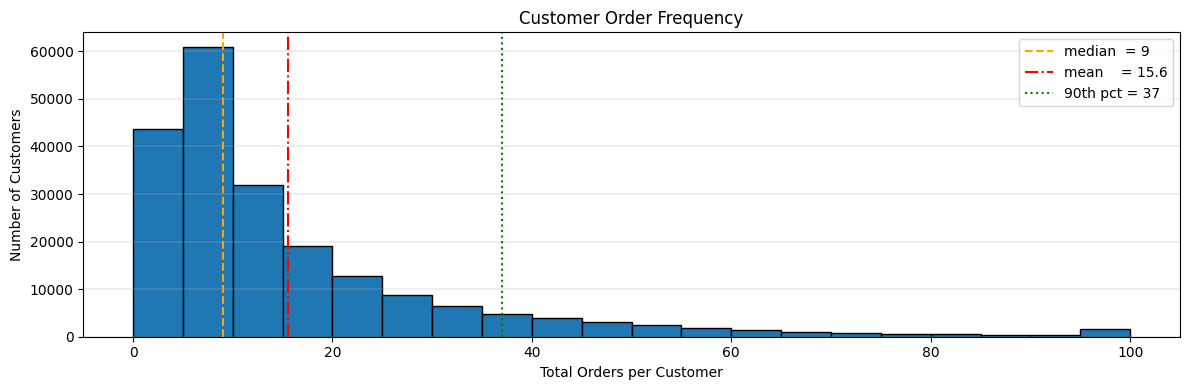

In [35]:
# histogram edges every 5 orders:
bins = np.arange(0, user_total_orders.max() + 5, 5)

fig, ax = plt.subplots(figsize=(12, 4))

# bars with thin black edges so each bin is distinct:
ax.hist(user_total_orders, bins=bins, edgecolor="black")

# summary stats:
median = user_total_orders.median()
mean   = user_total_orders.mean()
p90    = user_total_orders.quantile(0.90)

# reference lines in different colours:
ax.axvline(median, color="orange",  linestyle="--", linewidth=1.5, label=f"median  = {median:.0f}")
ax.axvline(mean,   color="red",     linestyle="-.", linewidth=1.5, label=f"mean    = {mean:.1f}")
ax.axvline(p90,    color="green",   linestyle=":",  linewidth=1.5, label=f"90th pct = {p90:.0f}")

# labels & formatting:
ax.set_xlabel("Total Orders per Customer")
ax.set_ylabel("Number of Customers")
ax.set_title("Customer Order Frequency")
ax.grid(axis="y", linewidth=0.3)
ax.legend()
plt.tight_layout()
plt.show()

**Customer Order Frequency - Highlights**

* Most shoppers are light users. Half the customer base places 9 orders or fewer (median).
* Average sits at 15.6 orders, pulled up by a long tail of heavy buyers.
* Power-users are rare but valuable. Only 10 % of shoppers go past 37 orders, yet some hit 100.
* The skewed curve suggests segmenting campaigns: retention nudges for light users vs. loyalty rewards for the high-order elite.

#### **Avg basket size**

Signals cart value and propensity to add extras.

In [36]:
avg_basket_size = (
    prior_full.groupby("user_id")["product_id"]
              .count()
              .div(user_total_orders)     # divide by lifetime orders
              .rename("avg_basket_size")
)

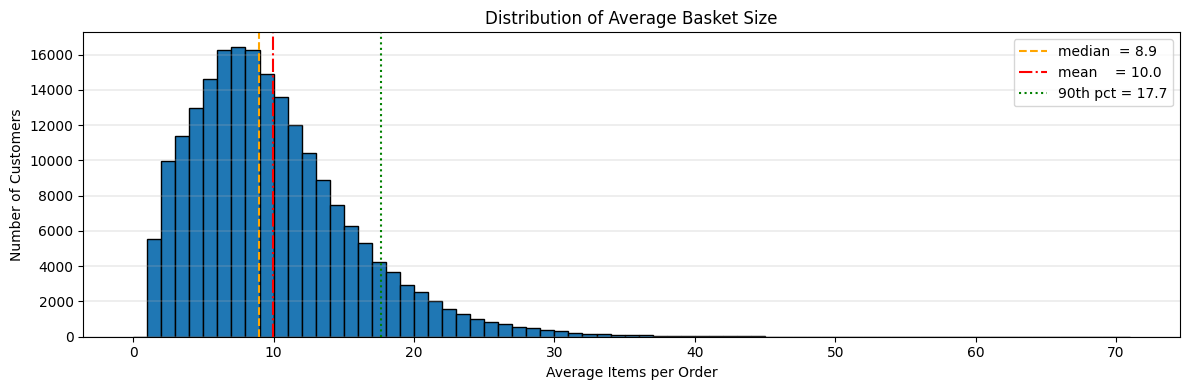

In [37]:
# avg_basket_size was created earlier:
mean_bs   = avg_basket_size.mean()
median_bs = avg_basket_size.median()
p90_bs    = avg_basket_size.quantile(0.90)

fig, ax = plt.subplots(figsize=(12, 4))

# Histogram with thin edges so bins pop:
bins = np.arange(0, avg_basket_size.max() + 1, 1)
ax.hist(avg_basket_size, bins=bins, edgecolor="black")

# Reference lines:
ax.axvline(median_bs, linestyle="--", linewidth=1.5, color="orange", label=f"median  = {median_bs:.1f}")
ax.axvline(mean_bs,   linestyle="-.", linewidth=1.5, color="red",    label=f"mean    = {mean_bs:.1f}")
ax.axvline(p90_bs,    linestyle=":",  linewidth=1.5, color="green",  label=f"90th pct = {p90_bs:.1f}")

ax.set_xlabel("Average Items per Order")
ax.set_ylabel("Number of Customers")
ax.set_title("Distribution of Average Basket Size")
ax.grid(axis="y", linewidth=0.3)
ax.legend()
plt.tight_layout()
plt.show()

**Average Basket Size - Highlights**

* Typical cart is modest. Half of customers average ~9 items or fewer per order.
* Mean creeps up to 10 thanks to a tail of bigger baskets.
* Heavy fillers are rare. Only 10 % of shoppers average more than 18 items.
* The right-skew hints at two segments: quick-trip shoppers vs. stock-up shoppers &rarr; This is useful when tailoring upsell or coupon strategies.

#### **Share of items flagged reordered**

High ratios mark habitual, brand-loyal shoppers.

In [38]:
avg_reorder_ratio = (
    prior_full.groupby("user_id")["reordered"]
              .mean()
              .rename("avg_reorder_ratio")
)

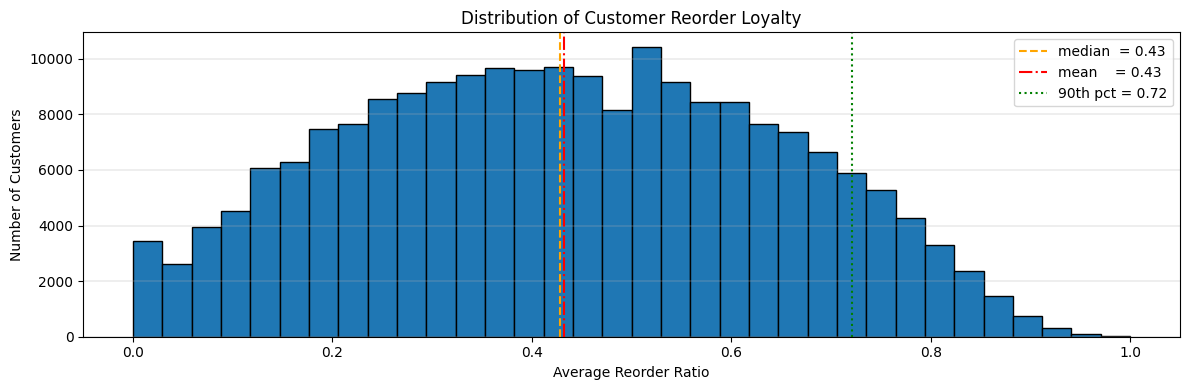

In [39]:
# avg_reorder_ratio was created earlier:
mean_rr   = avg_reorder_ratio.mean()
median_rr = avg_reorder_ratio.median()
p90_rr    = avg_reorder_ratio.quantile(0.90)

fig, ax = plt.subplots(figsize=(12, 4))

# Histogram with edges:
bins = np.linspace(0, 1, 35)
ax.hist(avg_reorder_ratio, bins=bins, edgecolor="black")

# Reference lines:
ax.axvline(median_rr, linestyle="--",  linewidth=1.5, color="orange", label=f"median  = {median_rr:.2f}")
ax.axvline(mean_rr,   linestyle="-.",  linewidth=1.5, color="red",    label=f"mean    = {mean_rr:.2f}")
ax.axvline(p90_rr,    linestyle=":",   linewidth=1.5, color="green",  label=f"90th pct = {p90_rr:.2f}")

ax.set_xlabel("Average Reorder Ratio")
ax.set_ylabel("Number of Customers")
ax.set_title("Distribution of Customer Reorder Loyalty")
ax.grid(axis="y", linewidth=0.3)
ax.legend()
plt.tight_layout()
plt.show()

**Reorder Loyalty - Highlights**

* Typical shopper reorders a lot. Median and mean both sit around 43 % of items per basket.
* Top-loyal segment is small. Only 10 % of customers average a reorder ratio above 72 %.
* Distribution is broad (0 - 90 %), hinting at clear loyalty tiers to target differently.
* High-ratio shoppers may need fewer coupons, while low-ratio shoppers are prime for retention nudges.

#### **Mean gap in days between orders**

Captures purchase cadence; irregular gaps can hint churn risk.

In [40]:
avg_days_between = (
    prior_full.groupby("user_id")["days_since_prior_order"]
              .mean()
              .rename("avg_days_between")
)

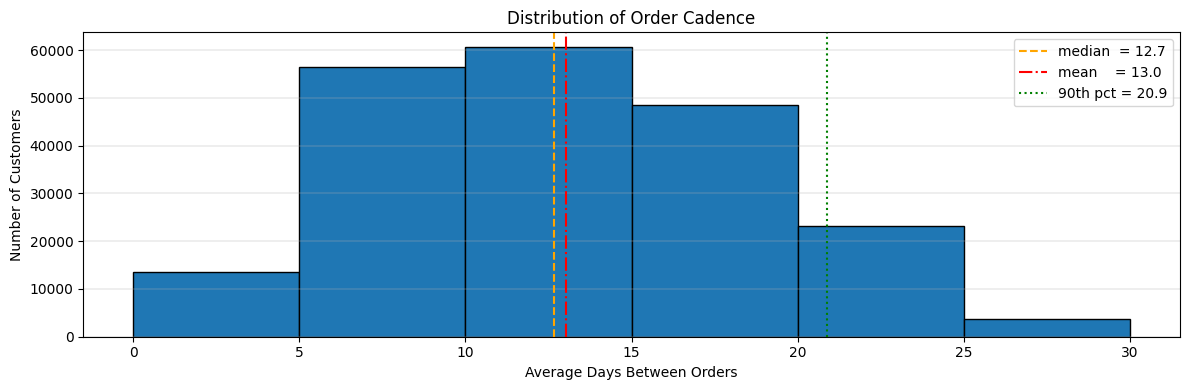

In [41]:
# avg_days_between was created earlier:
mean_gap   = avg_days_between.mean()
median_gap = avg_days_between.median()
p90_gap    = avg_days_between.quantile(0.90)

fig, ax = plt.subplots(figsize=(12, 4))

# Histogram with black bin edges for clarity:
bins = np.arange(0, avg_days_between.max() + 5, 5)
ax.hist(avg_days_between, bins=bins, edgecolor="black")

# Reference lines:
ax.axvline(median_gap, linestyle="--", linewidth=1.5, color="orange", label=f"median  = {median_gap:.1f}")
ax.axvline(mean_gap,   linestyle="-.", linewidth=1.5, color="red",    label=f"mean    = {mean_gap:.1f}")
ax.axvline(p90_gap,    linestyle=":",  linewidth=1.5, color="green",  label=f"90th pct = {p90_gap:.1f}")

ax.set_xlabel("Average Days Between Orders")
ax.set_ylabel("Number of Customers")
ax.set_title("Distribution of Order Cadence")
ax.grid(axis="y", linewidth=0.3)
ax.legend()
plt.tight_layout()
plt.show()

**Order Cadence - Highlights**

* Weekly rhythm dominates. The typical shopper places a new basket roughly every 13 days (median &approx; mean).
* Most return within two weeks. 90 % of customers average &le;  21 days between orders.
* Long gaps are rare. Only a thin tail stretches past three weeks, hinting at occasional stock-up rather than churn.
* Cadence consistency suggests time-based triggers (e.g., reminder emails at day 10) could hit shoppers just before they naturally reorder.

#### **Typical purchase time**

Useful for time-aware models and scheduling promos.

avg_order_hour & avg_order_dow

In [42]:
summary = summarize(prior_full)
summary

,feature,unique_count,data_types,missing_counts,missing_percentage
0,user_id,206209,int32,0,0.0
1,order_id,3214874,int32,0,0.0
2,aisle_id,134,int16,0,0.0
3,aisle,134,category,0,0.0
4,department_id,21,int8,0,0.0
5,department,21,category,0,0.0
6,product_id,49677,int32,0,0.0
7,product_name,49677,object,0,0.0
8,order_number,99,int16,0,0.0
9,order_dow,7,category,0,0.0


In [43]:
value_counts_with_percentage(prior_full, 'order_dow')

,Count,Percentage
order_dow,,
sunday,6209666,19.145256
monday,5665856,17.468615
saturday,4500304,13.875058
tuesday,4217798,13.004053
friday,4209533,12.978570
wednesday,3844117,11.851943
thursday,3787215,11.676506


In [44]:
# map day names (lower-case):
name_to_num = {
    "sunday": 0, "monday": 1, "tuesday": 2,
    "wednesday": 3, "thursday": 4, "friday": 5, "saturday": 6
}

prior_full["order_dow_num"] = (
    prior_full["order_dow"]
        .map(name_to_num)
        .astype("int8")
)

In [45]:
value_counts_with_percentage(prior_full, 'order_dow')

,Count,Percentage
order_dow,,
sunday,6209666,19.145256
monday,5665856,17.468615
saturday,4500304,13.875058
tuesday,4217798,13.004053
friday,4209533,12.978570
wednesday,3844117,11.851943
thursday,3787215,11.676506


In [46]:
avg_order_hour = (prior_full.groupby("user_id")["order_hour_of_day"].mean()
                             .rename("avg_order_hour"))
avg_order_dow  = (prior_full.groupby("user_id")["order_dow_num"].mean()
                             .rename("avg_order_dow"))

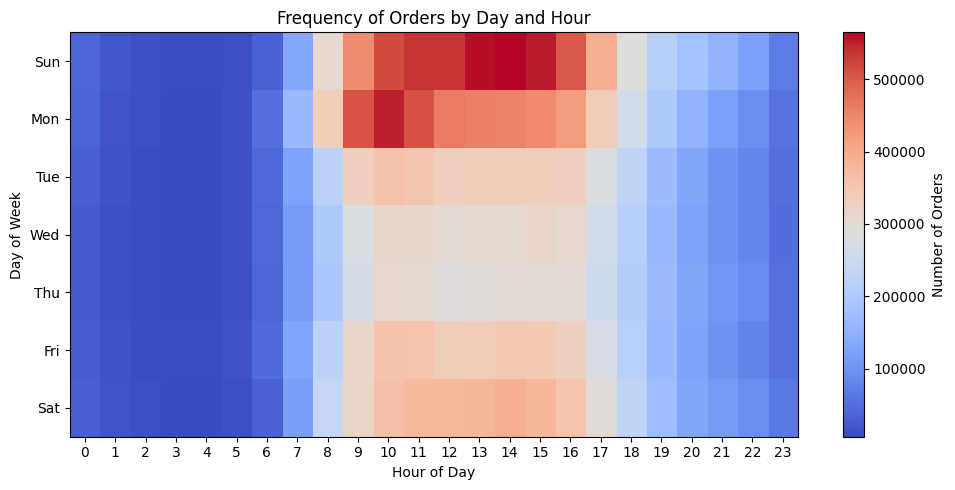

In [47]:
# Day-of-Week × Hour heatmap – shows when orders peak

# build the day-hour matrix:
heat = (
    prior_full
      .groupby(["order_dow_num", "order_hour_of_day"])
      .size()
      .unstack(fill_value=0)
      .loc[range(7)]          # rows 0-6 = Sun-Sat
)

#plot:
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(heat.values, aspect="auto", cmap="coolwarm")

# axis labels:
ax.set_xticks(range(24))
ax.set_xticklabels(range(24))
ax.set_yticks(range(7))
ax.set_yticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])

ax.set_xlabel("Hour of Day")
ax.set_ylabel("Day of Week")
ax.set_title("Frequency of Orders by Day and Hour")

# colour bar:
fig.colorbar(im, ax=ax, label="Number of Orders")

plt.tight_layout()
plt.show()

**Order Timing - Highlights**

* Mid-morning to mid-afternoon is prime. Volume climbs after 8AM and peaks between 10AM - 3PM across every day.
* Sunday and Monday are busiest. Sunday tops the chart, with Monday a close second—ideal windows for weekly-plan promos.
* Evenings taper fast. Activity drops sharply after 5PM, suggesting limited payoff for late-day pushes.
* Weekday pattern is steady. Tu-Fri look alike, implying one unified weekday strategy works.
* Overnight traffic is negligible. Hours 0-6AM see minimal orders; resources can skip these slots.
* These rhythms guide send-times for coupons and model features that weight daytime and weekday effects

#### **Assemble the shopper feature table**

These metrics will feed directly into the model and also drive targeted campaign decisions (e.g., coupons for low-order-count customers, nighttime offers for late shoppers).

In [48]:
base_feats = (
    pd.concat(
        [user_total_orders,
         avg_basket_size,
         avg_reorder_ratio,
         avg_days_between,
         avg_order_hour,
         avg_order_dow],
        axis=1
    )
)
base_feats = base_feats.reset_index()
base_feats.head()

,user_id,user_total_orders,avg_basket_size,avg_reorder_ratio,avg_days_between,avg_order_hour,avg_order_dow
0,1,10,5.900000,0.694915,18.542373,10.542373,2.644068
1,2,14,13.928571,0.476923,14.902564,10.441026,2.005128
2,3,12,7.333333,0.625000,10.181818,16.352273,1.011364
3,4,5,3.600000,0.055556,11.944444,13.111111,4.722222
4,5,4,9.250000,0.378378,10.189189,15.729730,1.621622


In [49]:
save_path = "/content/drive/My Drive/Colab Notebooks/base_feats.parquet"

base_feats.to_parquet(save_path, index=False)
print("Saved to:", save_path)

Saved to: /content/drive/My Drive/Colab Notebooks/base_feats.parquet


### **Time-Level Metrics**  

These features keep the *shape* of when each shopper orders instead of flattening it into a single average.

**Features built**

| feature(s) | note |
|------------|------|
| `how_sin`, `how_cos` | 168-hour clock captured as sine/cosine pair; preserves cyclic order without one-hot explosion |
| `peak_hour` | single hour (0-23) the shopper buys most often |
| `peak_dow`  | favourite weekday (0 = Sun … 6 = Sat) |
| `ratio_AM`, `ratio_PM`, `ratio_Even` | share of orders in morning (0-11), afternoon (12-17), evening (18-23) |
| `gap_<7`, `gap_7-14`, `gap_>14` | proportion of orders placed within <7 days, 7-14 days, and >14 days of the previous order |
| `hour_entropy` | routine vs. spontaneous behaviour; low entropy &rarr; predictable schedule |

#### **Hour-of-Week Sine / Cosine**

Captures a full 168-hour clock in two smooth numbers (perfect for tree or linear models).

In [50]:
# hour 0–167: Sunday-00h --> 0 … Saturday-23h --> 167
prior_full["hour_of_week"] = (
    prior_full["order_dow_num"] * 24 + prior_full["order_hour_of_day"]
)

prior_full["how_sin"] = np.sin(2 * np.pi * prior_full.hour_of_week / 168)
prior_full["how_cos"] = np.cos(2 * np.pi * prior_full.hour_of_week / 168)

#### **Peak Hour & Peak Day**

The single hour and weekday each shopper uses most—good categorical signals.

In [51]:
peak_hour = (
    prior_full.groupby("user_id")["order_hour_of_day"]
              .agg(lambda x: x.value_counts().idxmax())
              .rename("peak_hour")
)

peak_dow = (
    prior_full.groupby("user_id")["order_dow_num"]
              .agg(lambda x: x.value_counts().idxmax())
              .rename("peak_dow")
)

#### **Day-Part Ratios**

Morning vs. afternoon vs. evening share per customer (adds texture).

In [52]:
# label every order line as AM, PM, or Evening
daypart = pd.cut(
    prior_full["order_hour_of_day"],
    bins=[-1, 11, 17, 24],
    labels=["AM", "PM", "Even"]
)

ratios = (
    prior_full.assign(part=daypart)
              .pivot_table(index="user_id",
                           columns="part",
                           values="order_id",
                           aggfunc="count",
                           fill_value=0)
)
ratios = ratios.div(ratios.sum(axis=1), axis=0)  # convert to %
ratios.head()

/tmp/ipython-input-52-1491083264.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(index="user_id",


part,AM,PM,Even
user_id,,,
1,0.576271,0.423729,0.000000
2,0.846154,0.153846,0.000000
3,0.000000,0.784091,0.215909
4,0.333333,0.666667,0.000000
5,0.000000,0.540541,0.459459


#### **Cadence Buckets**

How frequently each shopper returns (< 7 days, 7-14, > 14).
Great for churn risk.

In [53]:
gap_bucket = pd.cut(
    prior_full["days_since_prior_order"],
    bins=[0, 7, 14, np.inf],
    labels=["<7", "7-14", ">14"]
)

gap_pct = (
    prior_full.assign(bucket=gap_bucket)
              .pivot_table(index="user_id",
                           columns="bucket",
                           values="order_id",
                           aggfunc="count",
                           fill_value=0)
)
gap_pct = gap_pct.div(gap_pct.sum(axis=1), axis=0)
gap_pct.head()

/tmp/ipython-input-53-4217171084.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(index="user_id",


bucket,<7,7-14,>14
user_id,,,
1,0.000000,0.125000,0.875000
2,0.076923,0.598901,0.324176
3,0.384615,0.320513,0.294872
4,0.000000,0.000000,1.000000
5,0.000000,0.538462,0.461538


#### **Hourly Entropy**

* Low entropy &rarr; routine buyer
* High entropy &rarr; scattered schedule.

In [54]:
hour_hist = (
    prior_full
      .groupby(["user_id", "order_hour_of_day"])
      .size()
      .unstack(fill_value=0)
)  # rows = users, cols = 0-23

hour_entropy = hour_hist.apply(
    lambda r: entropy(r, base=2), axis=1
).rename("hour_entropy")
hour_entropy.head()

,hour_entropy
user_id,
1,2.659844
2,2.097470
3,2.477860
4,1.571542
5,1.531887


In [55]:
# time-pattern block:
time_feats = pd.concat(
    [peak_hour, peak_dow, ratios, gap_pct, hour_entropy],
    axis=1
)

In [56]:
save_path = "/content/drive/My Drive/Colab Notebooks/time_feats.parquet"

time_feats.to_parquet(save_path, index=False)
print("Saved to:", save_path)

Saved to: /content/drive/My Drive/Colab Notebooks/time_feats.parquet


In [58]:
# combine --> final shopper_features:
shopper_features = (
    base_feats
      .merge(time_feats, left_index=True, right_index=True)
      .reset_index(drop=False)
      .rename_axis(None)
)
shopper_features = shopper_features.drop(columns="index")
shopper_features.head()

,user_id,user_total_orders,avg_basket_size,avg_reorder_ratio,avg_days_between,avg_order_hour,avg_order_dow,peak_hour,peak_dow,AM,PM,Even,<7,7-14,>14,hour_entropy
0,2,14,13.928571,0.476923,14.902564,10.441026,2.005128,7,4,0.576271,0.423729,0.000000,0.000000,0.125000,0.875000,2.659844
1,3,12,7.333333,0.625000,10.181818,16.352273,1.011364,9,2,0.846154,0.153846,0.000000,0.076923,0.598901,0.324176,2.097470
2,4,5,3.600000,0.055556,11.944444,13.111111,4.722222,16,0,0.000000,0.784091,0.215909,0.384615,0.320513,0.294872,2.477860
3,5,4,9.250000,0.378378,10.189189,15.729730,1.621622,15,4,0.333333,0.666667,0.000000,0.000000,0.000000,1.000000,1.571542
4,6,3,4.666667,0.142857,5.571429,17.000000,3.857143,18,3,0.000000,0.540541,0.459459,0.000000,0.538462,0.461538,1.531887


In [59]:
shopper_features.shape

(206208, 16)

In [60]:
save_path = "/content/drive/My Drive/Colab Notebooks/shopper_features.parquet"

shopper_features.to_parquet(save_path, index=False)
print("Saved to:", save_path)

Saved to: /content/drive/My Drive/Colab Notebooks/shopper_features.parquet


### **Product-Level Table**  

here let's capture how each SKU behaves across the whole catalogue—its popularity, loyalty signal, and category.  
These features help the model tell best-sellers from niche items and spot products that regularly get re-added.

| feature | what it measures | why it matters |
|---------|-----------------|----------------|
| `prod_total_orders` | Total times the product appears in any basket | Popularity baseline; hot SKUs need different offers from slow movers |
| `prod_times_reordered` | Count of orders where `reordered = 1` | Raw loyalty signal before normalising |
| `prod_reorder_prob` | `prod_times_reordered / prod_total_orders` | Likelihood that a buyer re-adds the item; high values often need no coupon |
| `prod_days_since_last_seen` | Global orders elapsed since the product last appeared | Freshness; new launches vs. fading items |
| `aisle`, `department` | Categorical look-ups | Lets the model see cross-category affinities and enables aisle-level guardrails |


In [62]:
# highest order_number in the whole dataset:
max_order_idx = prior_full["order_number"].max()

prod_feat = (
    prior_full.groupby("product_id")
      .agg(
          prod_total_orders    = ("order_id",  "count"),
          prod_times_reordered = ("reordered", "sum"),
          prod_last_order      = ("order_number", "max"),
          aisle                = ("aisle", "first"),
          department           = ("department", "first"),
      )
      .assign(
          prod_reorder_prob        = lambda d: d.prod_times_reordered / d.prod_total_orders,
          prod_days_since_last_seen= lambda d: max_order_idx - d.prod_last_order
      )
      .drop(columns="prod_last_order")
)
prod_feat = prod_feat.reset_index()
prod_feat.head()

,product_id,prod_total_orders,prod_times_reordered,aisle,department,prod_reorder_prob,prod_days_since_last_seen
0,1,1852,1136,cookies cakes,snacks,0.613391,2
1,2,90,12,spices seasonings,pantry,0.133333,7
2,3,277,203,tea,beverages,0.732852,4
3,4,329,147,frozen meals,frozen,0.446809,40
4,5,15,9,marinades meat preparation,pantry,0.600000,79


In [63]:
prod_feat.shape

(49677, 7)

In [64]:
save_path = "/content/drive/My Drive/Colab Notebooks/prod_feat.parquet"

prod_feat.to_parquet(save_path, index=False)
print("Saved to:", save_path)

Saved to: /content/drive/My Drive/Colab Notebooks/prod_feat.parquet


Now ***prod_days_since_last_seen*** is simply "how many orders ago did we last see this SKU", with no external variables needed.

### **User x Product Interaction**

This block zooms in on the personal relationship between each shopper and each SKU.  
It captures how recently and how often a customer buys an item, plus context about where it lands in the cart.  
These signals are the core of any next-basket model.

| feature | what it measures | why it matters |
|---------|-----------------|----------------|
| `usr_prod_times_bought` | lifetime times the shopper purchased the item | Raw “familiarity” score; frequent pairs suggest habit |
| `orders_since_last` | how many orders ago the item was last bought | Recency—short gaps raise purchase likelihood |
| `days_since_last` | literal days gap (uses `days_since_prior_order`) | Captures irregular ordering schedules |
| `last_cart_pos_norm` | last add-to-cart position ÷ basket size | Early-cart items are staples; late adds are add-ons |
| `last_order_number` | The shopper's most-recent order index where the item appeared. | Needed to compute recency |
| `last_cart_pos` | Add-to-cart position on the last purchase (1 = first item). | Early positions imply staples; late ones are add-ons. |


In [65]:
# shopper_features already holds user_total_orders and avg_basket_size
# now let's make sure the index is user_id for a fast merge
shopper_tbl = shopper_features.set_index("user_id")

# user × product block:
latest = (
    prior_full.sort_values("order_number")
              .drop_duplicates(["user_id", "product_id"], keep="last")
              .loc[:, ["user_id", "product_id",
                       "order_number", "days_since_prior_order",
                       "add_to_cart_order"]]
              .rename(columns={
                  "order_number": "last_order_number",
                  "days_since_prior_order": "days_since_last",
                  "add_to_cart_order": "last_cart_pos"
              })
)

usr_prod = (
    prior_full.groupby(["user_id", "product_id"])
              .agg(usr_prod_times_bought=("order_id", "count"))
              .reset_index()
    .merge(latest, on=["user_id", "product_id"])
    .merge(
        shopper_tbl[["user_total_orders", "avg_basket_size"]],
        left_on="user_id", right_index=True
    )
    .assign(
        orders_since_last   = lambda d: d.user_total_orders - d.last_order_number,
        last_cart_pos_norm  = lambda d: d.last_cart_pos / d.avg_basket_size
    )
    .drop(columns=["user_total_orders", "avg_basket_size"])
)
usr_prod = usr_prod.reset_index(drop=True)
usr_prod.head()

,user_id,product_id,usr_prod_times_bought,last_order_number,days_since_last,last_cart_pos,orders_since_last,last_cart_pos_norm
0,2,23,1,8,27,12,6,0.861538
1,2,79,1,13,30,3,1,0.215385
2,2,1559,6,14,13,3,0,0.215385
3,2,2002,4,11,30,14,3,1.005128
4,2,2573,2,14,13,12,0,0.861538


In [66]:
usr_prod.shape

(13307935, 8)

In [67]:
save_path = "/content/drive/My Drive/Colab Notebooks/usr_prod.parquet"

usr_prod.to_parquet(save_path, index=False)
print("Saved to:", save_path)

Saved to: /content/drive/My Drive/Colab Notebooks/usr_prod.parquet


**Together these features let the model answer questions like:**

* Is this user a repeat buyer of the item?
* Has it been a long time since they last bought it?
* Was the product a first-in-cart staple or a last-minute impulse add?

Those personal signals combine with the shopper-level, time-pattern, and product-level blocks to form the full feature set for next-basket prediction.

### **Putting the Feature Blocks Together**

We now have three feature tables, each capturing a different slice of behaviour:

| table | index / keys | scope | what it adds |
|-------|--------------|-------|--------------|
| **`shopper_features`** | `user_id` | 206 K shoppers | global habits & timing (basket size, cadence, peak hours…) |
| **`prod_feat`** | `product_id` | 49 K SKUs | popularity & loyalty of every item |
| **`usr_prod`** | `user_id`, `product_id` | 13 M shopper-item pairs* | personal recency, frequency, cart position |

\* only the `(user, product)` pairs that have actually occurred in purchase history.

## **Modeling Dataset Assembly**

We'll stitch the three feature blocks into one **candidate matrix** and attach the training label.  
The result is a row-per-shopper-item table ready for Modeling.

### **Start from the user-item interactions**

`usr_prod` already contains every *(user_id, product_id)* pair that matters.

In [68]:
candidates = usr_prod.copy()    # 13 M rows

### **Merge shopper-level features**



In [69]:
candidates = candidates.merge(
    shopper_features, on="user_id", how="left"
)



### **Merge product-level features**

In [70]:
candidates = candidates.merge(
    prod_feat, on="product_id", how="left"
)

In [71]:
candidates.shape

(13307935, 29)

In [72]:
candidates.head()

,user_id,product_id,usr_prod_times_bought,last_order_number,days_since_last,last_cart_pos,orders_since_last,last_cart_pos_norm,user_total_orders,avg_basket_size,...,<7,7-14,>14,hour_entropy,prod_total_orders,prod_times_reordered,aisle,department,prod_reorder_prob,prod_days_since_last_seen
0,2,23,1,8,27,12,6,0.861538,14,13.928571,...,0.0,0.125,0.875,2.659844,1068,479,packaged poultry,meat seafood,0.448502,4
1,2,79,1,13,30,3,1,0.215385,14,13.928571,...,0.0,0.125,0.875,2.659844,3585,1916,canned meat seafood,canned goods,0.534449,0
2,2,1559,6,14,13,3,0,0.215385,14,13.928571,...,0.0,0.125,0.875,2.659844,6858,5023,yogurt,dairy eggs,0.732429,0
3,2,2002,4,11,30,14,3,1.005128,14,13.928571,...,0.0,0.125,0.875,2.659844,2832,1533,frozen vegan vegetarian,frozen,0.541314,1
4,2,2573,2,14,13,12,0,0.861538,14,13.928571,...,0.0,0.125,0.875,2.659844,1212,480,asian foods,international,0.396040,3


Alright now after these joins each row at candidates table now carries:

* shopper stats &harr; shopper_features
* product stats &harr; prod_feat
* interaction stats &harr; original usr_prod columns

In [73]:
save_path = "/content/drive/My Drive/Colab Notebooks/candidates.parquet"

candidates.to_parquet(save_path, index=False)
print("Saved to:", save_path)

Saved to: /content/drive/My Drive/Colab Notebooks/candidates.parquet


### **Building bought_next label**

Instacart splits each shoppers history like this:

| file | rows inside | purpose |
|------|-------------|---------|
| **`order_products__prior.csv`** | *every* past basket | build **features** (what happened before) |
| **`order_products__train.csv`** | the shopper's very **next** basket | provide **labels** (what we must predict) |

`order_products__train.csv` (`order_train` DataFrame) lists the **product lines** the customer actually bought in that hold-out order — but it does **not** include `user_id`.


In [74]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [75]:
value_counts_with_percentage(orders, 'eval_set')

,Count,Percentage
eval_set,,
prior,3214874,93.972406
train,131209,3.835306
test,75000,2.192288


In [77]:
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [78]:
#First let's grab just the orders flagged as 'train' so we can map order_id --> user_id
train_orders = orders.loc[orders.eval_set == "train", ["order_id", "user_id"]]
train_orders.head()

,order_id,user_id
10,1187899,1
25,1492625,2
49,2196797,5
74,525192,7
78,880375,8


In [79]:
# Then let's attach user_id to every product line in order_products__train
labels = (
    train                             # rows from order_products__train.csv
      .merge(train_orders, on="order_id")
      .loc[:, ["user_id", "product_id"]]
      .assign(bought_next=1)
)

In [80]:
labels.head()

,user_id,product_id,bought_next
0,112108,49302,1
1,112108,11109,1
2,112108,10246,1
3,112108,49683,1
4,112108,43633,1


In [81]:
# Now, let's merge labels onto the candidate matrix:
candidates = (
    candidates # usr_prod + shopper + product features
      .merge(labels, on=["user_id", "product_id"], how="left")
)

#Finally, any pair not present in train basket is a negative class (0):
candidates["bought_next"] = candidates["bought_next"].fillna(0).astype("int8")

In [82]:
candidates.head()

,user_id,product_id,usr_prod_times_bought,last_order_number,days_since_last,last_cart_pos,orders_since_last,last_cart_pos_norm,user_total_orders,avg_basket_size,...,7-14,>14,hour_entropy,prod_total_orders,prod_times_reordered,aisle,department,prod_reorder_prob,prod_days_since_last_seen,bought_next
0,2,23,1,8,27,12,6,0.861538,14,13.928571,...,0.125,0.875,2.659844,1068,479,packaged poultry,meat seafood,0.448502,4,0
1,2,79,1,13,30,3,1,0.215385,14,13.928571,...,0.125,0.875,2.659844,3585,1916,canned meat seafood,canned goods,0.534449,0,0
2,2,1559,6,14,13,3,0,0.215385,14,13.928571,...,0.125,0.875,2.659844,6858,5023,yogurt,dairy eggs,0.732429,0,0
3,2,2002,4,11,30,14,3,1.005128,14,13.928571,...,0.125,0.875,2.659844,2832,1533,frozen vegan vegetarian,frozen,0.541314,1,0
4,2,2573,2,14,13,12,0,0.861538,14,13.928571,...,0.125,0.875,2.659844,1212,480,asian foods,international,0.396040,3,0


**Alright now candidates table has:**

* Shopper features (shopper_features)
* Product features (prod_feat)
* User-item interaction features (usr_prod)
* bought_next flag: the target column for model training.

In [83]:
save_path = "/content/drive/My Drive/Colab Notebooks/candidates_v1.parquet"

candidates.to_parquet(save_path, index=False)
print("Saved to:", save_path)

Saved to: /content/drive/My Drive/Colab Notebooks/candidates_v1.parquet


In [84]:
candidates.shape

(13307935, 30)

In [85]:
summary = summarize(candidates)
summary

,feature,unique_count,data_types,missing_counts,missing_percentage
0,user_id,206208,int32,0,0.000000
1,product_id,49677,int32,0,0.000000
2,usr_prod_times_bought,99,int64,0,0.000000
3,last_order_number,99,int16,0,0.000000
4,days_since_last,31,int16,0,0.000000
5,last_cart_pos,140,int16,0,0.000000
6,orders_since_last,99,int64,0,0.000000
7,last_cart_pos_norm,275932,float64,0,0.000000
8,user_total_orders,97,int64,0,0.000000
9,avg_basket_size,18929,float64,0,0.000000


In [86]:
ratio_cols = ["<7", "7-14", ">14"]

candidates[ratio_cols] = (
    candidates[ratio_cols]
      .fillna(0)
      .astype("float32")
)

In [87]:
summary = summarize(candidates)
summary

,feature,unique_count,data_types,missing_counts,missing_percentage
0,user_id,206208,int32,0,0.0
1,product_id,49677,int32,0,0.0
2,usr_prod_times_bought,99,int64,0,0.0
3,last_order_number,99,int16,0,0.0
4,days_since_last,31,int16,0,0.0
5,last_cart_pos,140,int16,0,0.0
6,orders_since_last,99,int64,0,0.0
7,last_cart_pos_norm,275932,float64,0,0.0
8,user_total_orders,97,int64,0,0.0
9,avg_basket_size,18929,float64,0,0.0


In [88]:
save_path = "/content/drive/My Drive/Colab Notebooks/candidates_v1.parquet"

candidates.to_parquet(save_path, index=False)
print("Saved to:", save_path)

Saved to: /content/drive/My Drive/Colab Notebooks/candidates_v1.parquet


#### **Sanity Checks & Outlier Flags**

Tree models tolerate rough scales, but trimming extreme values speeds training and cuts noise. Alrightm so let's look at our numerical features and see which feature we'll need to trim to help our modeling:

In [116]:
num_cols = candidates.select_dtypes("number").columns

# here let's use describe():
profile = (
    candidates[num_cols]
      .describe(percentiles=[0.99])     # rows: min, 25%, 50%, 75%, 99%, mean, std, max, count
      .T                                # switch to rows = feature names
      .rename(columns={"99%": "p99"})
      .loc[:, ["min", "50%", "mean", "std", "max", "p99"]]   # keep what we need
)

# add tail ratio:
profile["tail_ratio"] = profile["max"] / profile["p99"]

# sort by how extreme the tail is:
profile = profile.sort_values("tail_ratio", ascending=False)

profile.head(10)


,min,50%,mean,std,max,p99,tail_ratio
usr_prod_times_bought,1.000000,1.000000,2.437225,3.554528,99.000000,18.000000,5.500000
last_cart_pos_norm,0.014235,0.666667,0.741118,0.495390,11.942857,2.278302,5.241999
last_cart_pos,1.000000,7.000000,9.112035,7.469829,145.000000,34.000000,4.264706
avg_basket_size,1.000000,11.533333,12.700554,6.299273,70.250000,32.600000,2.154908
prod_days_since_last_seen,0.000000,0.000000,4.459834,11.555685,98.000000,59.000000,1.661017
orders_since_last,0.000000,4.000000,9.512776,13.416958,98.000000,66.000000,1.484848
prod_times_reordered,0.000000,2295.000000,15837.117903,44893.562053,398609.000000,315913.000000,1.261768
avg_order_hour,0.000000,13.500000,13.519418,1.958943,23.000000,18.377246,1.251548
prod_total_orders,1.000000,4306.000000,22499.031384,55872.326675,472565.000000,379450.000000,1.245395
avg_days_between,0.000000,10.834437,11.578438,5.280350,29.702970,24.574468,1.208692


In [117]:
#Based on above, let's trim the top-4 feature:

def winsorise(series, cap):
    return series.clip(upper=cap)

caps = {
    "usr_prod_times_bought": 18,
    "last_cart_pos": 34,
    "avg_basket_size": 33      }

for col, cap_val in caps.items():
    candidates[col] = winsorise(candidates[col], cap_val)

# ensure the normalised ratio is bounded
candidates["last_cart_pos_norm"] = candidates["last_cart_pos_norm"].clip(upper=1.0)

In [120]:
for col, cap in caps.items():
    n_capped = (candidates[col] == cap).sum()
    print(f"{col:<22}  capped rows: {n_capped:,}")

usr_prod_times_bought   capped rows: 146,096
last_cart_pos           capped rows: 150,447
avg_basket_size         capped rows: 125,021


### **Class Balance - pie view**

A quick pie chart shows the share of positives (`bought_next = 1`) and negatives (`0`) with both **percent** and **count (in k)**.

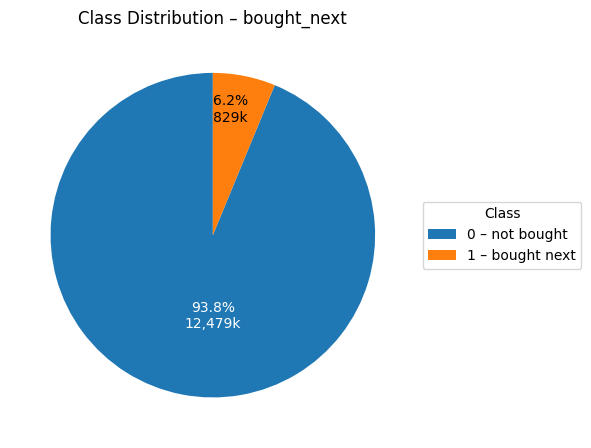

In [121]:
# counts & percents:
cnt = candidates["bought_next"].value_counts().sort_index()      # 0 then 1
pct = cnt / cnt.sum() * 100

# pie colours:
colors = ["#1f77b4", "#ff7f0e"]   # blue for 0, orange for 1

fig, ax = plt.subplots(figsize=(6, 6))

# draw pie:
wedges, _ = ax.pie(cnt, colors=colors, startangle=90)

# central stacked tex:
text0 = f"{pct[0]:.1f}%\n{cnt[0]/1_000:,.0f}k"
text1 = f"{pct[1]:.1f}%\n{cnt[1]/1_000:,.0f}k"

# position at small offsets so they don't overlap
ax.text(0, -0.50 , text0, ha="center", va="center", color="white", fontsize=10)
ax.text(0, 0.70 , text1, color="black", fontsize=10)

# legend mapping colour to meaning:
ax.legend(wedges,
          ["0 – not bought", "1 – bought next"],
          title="Class",
          loc="center left",
          bbox_to_anchor=(1, 0.5))

ax.set_title("Class Distribution – bought_next")
plt.tight_layout()
plt.show()


**Summary Highlights:**

* The model will see ~15 negatives for every positive.
* Tree-based Models handle this if we:
  * Set scale_pos_weight for XGBoost (pos_weight = negatives/positives) or class_weight (Random Forest/LightGBM) or
  * Use ensemble Models from imblearn Library such as Easy Ensemble, Balanced Random Forest, Balanced Bagging (LightGBM) and Easy Ensemble (LightGBM).
* Evaluation should rely on AUC-PR, recall, or F1. Accuracy would be misleading at 93 % by always predicting zero.

Addressing the imbalance is critical so the model learns to spot the 6 % of pairs that really matter for next-best-offer targeting.


In [122]:
save_path = "/content/drive/My Drive/Colab Notebooks/candidates_v2.parquet"

candidates.to_parquet(save_path, index=False)
print("Saved to:", save_path)

Saved to: /content/drive/My Drive/Colab Notebooks/candidates_v2.parquet
